# Quadrupolar Coupling Demo PULSEE

# Imports

In [1]:
import numpy as np
import pandas as pd
import qutip as qt
import matplotlib.pyplot as plt

import pulsee.simulation as sim
import pulsee.operators as op
import pulsee.plot as psplt

# Parameters

In [2]:
Ix, Iy, Iz = qt.spin_J_set(3 / 2)

In [3]:
qn = 3 / 2
gr = 1
B0 = 1
e2qQ = 0.1

B1 = 5e-1

spin_par = {'quantum number' : qn,
        'gamma/2pi' : gr}

zeem_par = {'field magnitude' : B0,
        'theta_z' : 0,
        'phi_z' : 0}

pulse_time = 2 / (4 * 3 * gr * B1)

In [4]:
etas = np.linspace(0, 1, 2)

# Simulation
Define simulation code which we will run with different solvers:

In [5]:
h_unperturbed=None
spin=None

In [6]:
def simulate(solver):
    global h_unperturbed
    global spin
    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : np.pi/2.,
                    'gamma_q' : 0.,
                    'order' : 0}
        
        mode = pd.DataFrame([( B0 * gr, B1, 0., np.pi/2, 0, pulse_time)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p', 'pulse_time'], )

        spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(spin_par, quad_par=quad_par,
                                            zeem_par=zeem_par, initial_state='canonical', temperature=1e-5)
        
        print('Initial_state')
        fig = psplt.plot_real_part_density_matrix(dm_initial)
#         print(np.round(dm_initial.full(), 3))
        opts = qt.Options(atol=1e-16, rtol=1e-16, rhs_reuse=False, nsteps=20000)
        dm_evolved = sim.evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, picture='RRF', n_points=60, opts=opts, order=1)
        
        print('Evolved_state')
        fig = psplt.plot_real_part_density_matrix(dm_evolved)
#         print(np.round(dm_evolved.full(), 3))
        t, FID = sim.FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=1800, \
                            T2=600, ref_freq=0, n_points=20000, opts=opts)

        f, ft = sim.fourier_transform_signal(FID, t, padding=2)
        fts.append([eta, f, ft, t, FID])
    return fts

In [7]:
h_unperturbed=None
spin=None

# Plots

Run simulations with Magnus solve

Initial_state


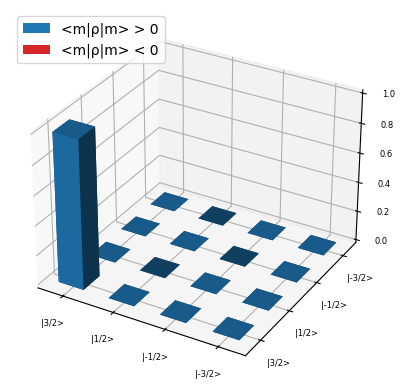

100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 620.58it/s]

Evolved_state


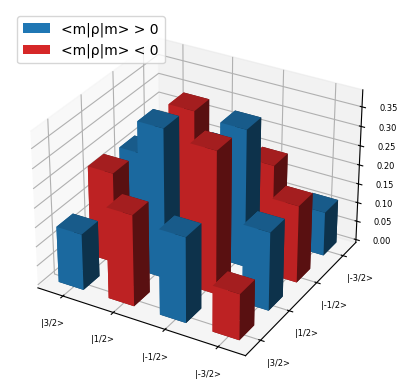

Initial_state


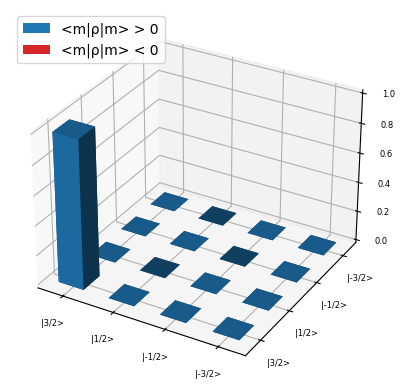

100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 570.92it/s]

Evolved_state


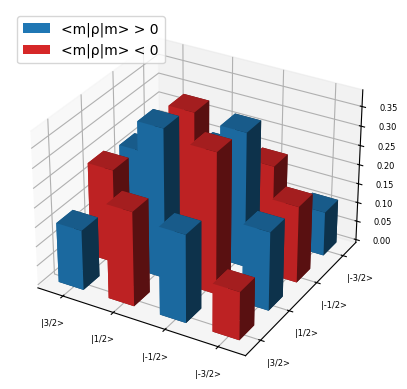

In [8]:
fts_magnus = simulate('magnus')

PRINTING OUT DIMS[0]: [4]


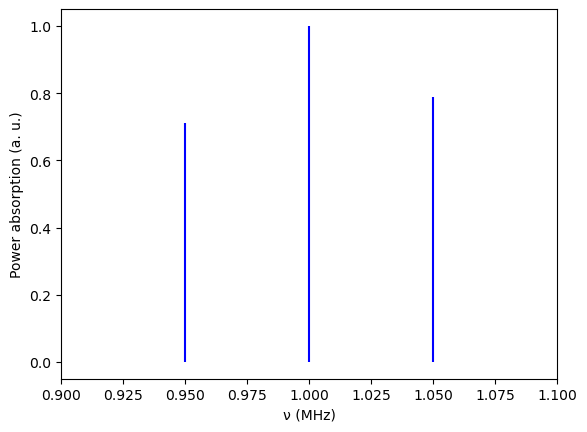

In [9]:
# Theoretically calculated where the expected transitions should be using the Fermi golden rule
f, p = sim.power_absorption_spectrum(spin, h_unperturbed, normalized=True)
_ = psplt.plot_power_absorption_spectrum(f, p, xlim=[.9, 1.1])

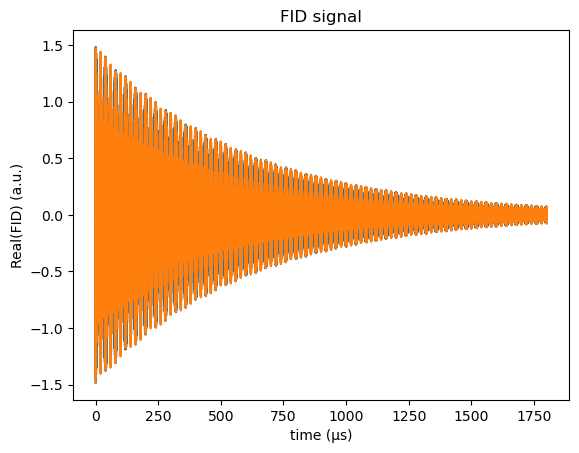

In [10]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid, in fts_magnus:
    psplt.plot_real_part_FID_signal(t, fid, figure = (fig, ax), show = False)
plt.show()

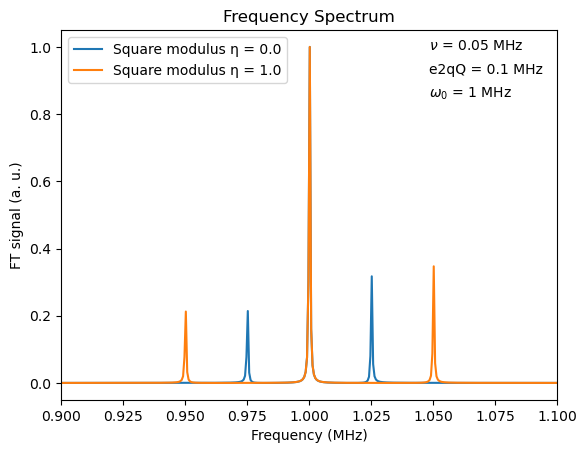

In [11]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_magnus:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(f, ft, square_modulus = True, xlim = [0.9, 1.1], figure = (fig, ax), 
                                   my_label=label, show = False)
    
plt.figtext(.7, .79, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.figtext(.7, .84, r'$\nu$ = ' + str(np.round(e2qQ/2, 3)) + ' MHz')
plt.figtext(.7, .74, r'$\omega_0$ = ' + str(np.round(gr * B0, 3)) + ' MHz')
plt.show()

Plot & solve mesolve solution QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve)::

Initial_state


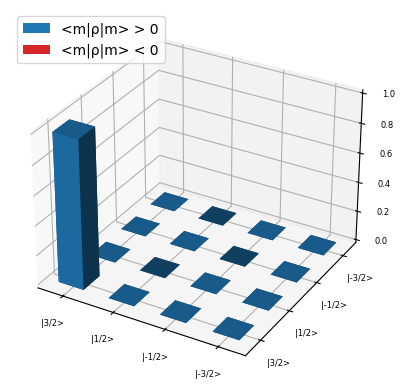

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.00s. Est. time left: 00:00:00:00
70.0%. Run time:   0.00s. Est. time left: 00:00:00:00
80.0%. Run time:   0.00s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s
Evolved_state


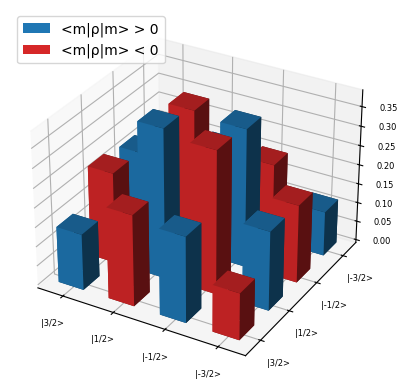

Initial_state


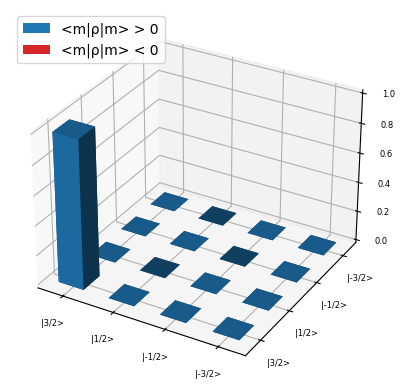

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.00s. Est. time left: 00:00:00:00
70.0%. Run time:   0.00s. Est. time left: 00:00:00:00
80.0%. Run time:   0.00s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s
Evolved_state


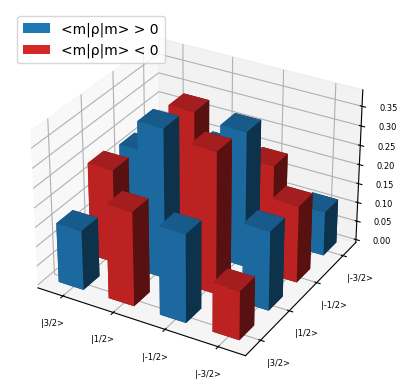

In [12]:
fts_mesolve = simulate('mesolve')

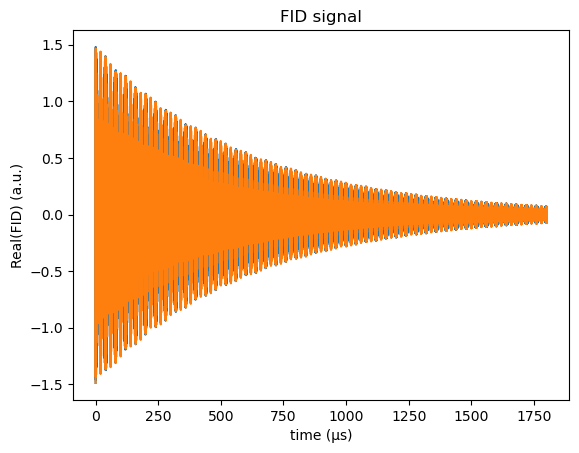

In [13]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid, in fts_mesolve:
    psplt.plot_real_part_FID_signal(t, fid, figure = (fig, ax), show = False)
plt.show()

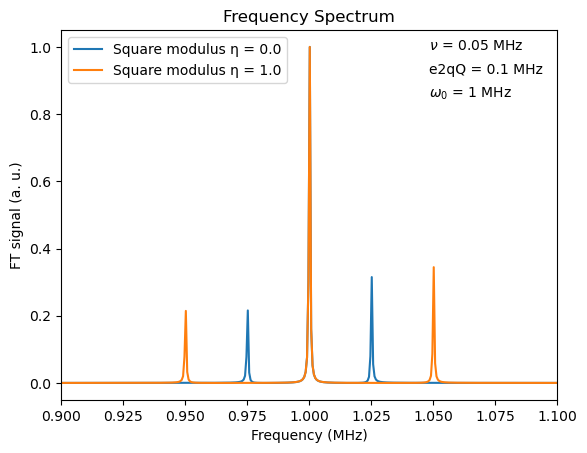

In [14]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_mesolve:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(f, ft, square_modulus = True, xlim = [0.9, 1.1], figure = (fig, ax), 
                                   my_label=label, show = False)
    
plt.figtext(.7, .79, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.figtext(.7, .84, r'$\nu$ = ' + str(np.round(e2qQ/2, 3)) + ' MHz')
plt.figtext(.7, .74, r'$\omega_0$ = ' + str(np.round(gr * B0, 3)) + ' MHz')
plt.show()

One must experiment with the pulse duration to find the exact $\pi/2$ pulse. This is hard because of the presence of the Zeeman term in the Hamiltonian. The spins are rotating during the evolution of the pulse with respect to the applied field. This is why the peaks for the $\eta = 0$ case are not exacly symmetric. 

Simulate with exact diagonalization approach:

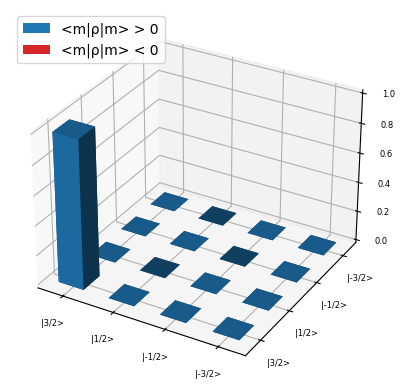

100%|███████████████████████████████████| 4000/4000 [00:00<00:00, 643199.51it/s]


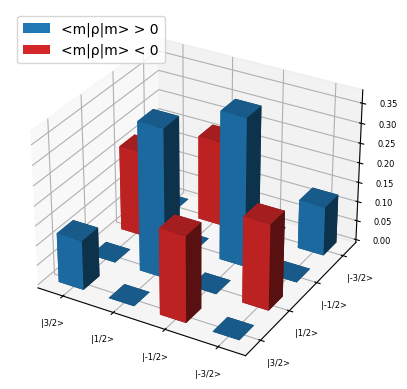

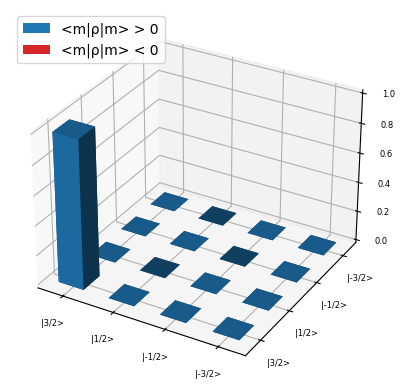

100%|███████████████████████████████████| 4000/4000 [00:00<00:00, 756446.01it/s]


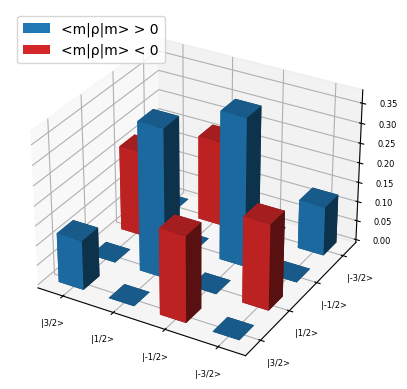

In [15]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : np.pi/2,
				'gamma_q' : 0.,
				'order' : 0}

	spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-5)
	fig = psplt.plot_real_part_density_matrix(dm_initial)  
    
	t = np.linspace(0, 800, 5*800) # 50 second acquisition time, 1000 data points

	iz, ix, iy = (spin.I['z'], spin.I['x'], spin.I['y'])

	rot_dm = op.apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = sim.ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, parallel=False, T2=100)
	fig = psplt.plot_real_part_density_matrix(dm_evolved)
	FID = e_ops[0]

	f, ft = sim.fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


Plot exact diagonalization solution:

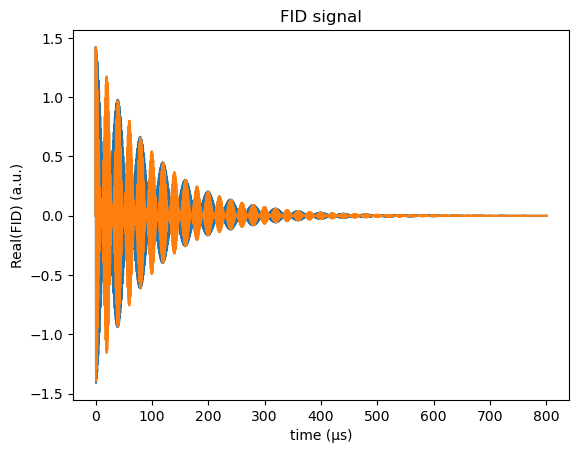

In [16]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid, in fts_ed:
    psplt.plot_real_part_FID_signal(t, fid, figure = (fig, ax), show = False)
plt.show()

Because of the idealized Ix pulse, exact diagonalization cannot exactly simulate experiments. 

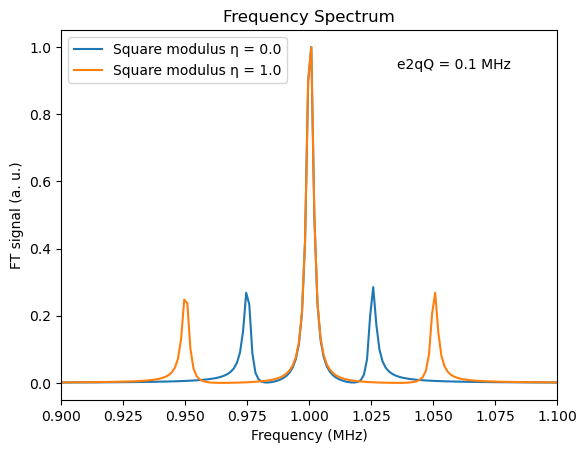

In [17]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_ed:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(f, ft, square_modulus = True, xlim = [0.9, 1.1], figure = (fig, ax), 
                                   my_label=label, show = False)
    
plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.show()

Because of the instatenous pulse, we have an exact $\pi/2$ pulse and the peaks for the $\eta = 0$ case are symmetric around the central peak. 

Simulate with exact diagonalization approach \& 2 different stretched exponential decays:

In [18]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : np.pi/2,
				'gamma_q' : 0.,
				'order' : 0}

	spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-5)

    
    
	t = np.linspace(0, 800, 5*800) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	rot_dm = op.apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = sim.ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, parallel=False, T2=[lambda t: np.exp(-(t/100)**1.5), lambda t: np.exp(-(t/100)**2)])
    
	FID = e_ops[0]

	f, ft = sim.fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


100%|███████████████████████████████████| 4000/4000 [00:00<00:00, 420565.93it/s]


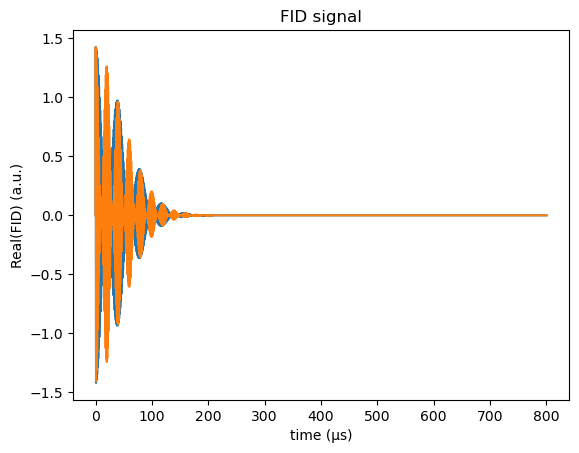

In [19]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid, in fts_ed:
    psplt.plot_real_part_FID_signal(t, fid, figure = (fig, ax), show = False)
plt.show()

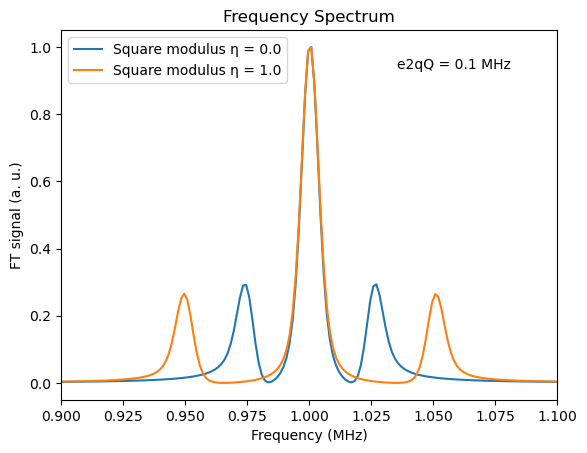

In [20]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_ed:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(f, ft, square_modulus = True, xlim = [0.9, 1.1], figure = (fig, ax), 
                                   my_label=label, show = False)

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.show()

The peaks here are broadened by two stetched exponentials $\exp(-(t/T_2)^\beta)$, where $T_2 = 100 \ \mu$s and $\beta = \{1.5, 2\}$.